#Stratégie adoptée

Obtenir des prédictions satisfaisantes avec ce dataset relève du défi. Si nous disposions d'une ferme de serveurs, nous pourrions utiliser RFECV pour sélectionner automatiquement les meilleures features. A défaut, nous allons tenter une stratégie moins gourmande :

1. Features importance

XGBoostRegressor va fournir une liste de features par ordre décroissant.



2. Forward selection

L'algorithme sera plus économe en ressources que RFECV parce qu'on intègrera au fur et à mesure les features les plus importantes, jusqu'à ce que le score n'augmente plus.

#1.Installation des librairies

Cette librairie, créée par les développeurs de scikit-learn, nous permettra d'effectuer une recherche d'optimisation bayésienne sur l'espace des hyperparamètres.
https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

In [ ]:
!pip install scikit-optimize

##1.2GLMM encoding

Dans leur papier, The scikit-learn library only provides a Target Encoder.
" [...] GLMMs are a major workhorse in applied statistics but not well understood and often neglected by the ML community."
Nous allons utiliser l'implémentation fournie par

In [ ]:
# the GLMM encoder
!pip install --upgrade category_encoders

##1.3Count Encoder

A la place du OneHotEncoding, nous allons utiliser un encoder qui a deux avantages:
- Il nous permet de conserver les informations concernant la distribution des catégories, car elles sont remplacées par leur occurrence au lieu d'un simple 1 ou 0.
- Il ne crée pas de colonnes supplémentaires, ce qui va nous faire grandement gagner en performance.
The implementation provided by category_encoders doesn't support multiple targets, so we use the one from feature-engine.
https://feature-engine.trainindata.com/en/latest/api_doc/encoding/CountFrequencyEncoder.html

Par contre, il a un désavantage : si une catégorie figure uniquement dans le test set, il ne connaîtra pas sa fréquence, donc il va créer des valeurs manquantes. Pour éviter ce cas de figure, nous allons regrouper les catégories rares
https://feature-engine.trainindata.com/en/latest/api_doc/encoding/RareLabelEncoder.html

In [ ]:
!pip install feature-engine

#2.Chargement des librairies

In [ ]:
# System
import os
from joblib import dump, load
from google.colab import files
import warnings

# Data
import pandas as pd
import numpy as np
import math
from scipy.stats import randint, uniform, loguniform

# Graphics
import matplotlib.pyplot as plt

# Machine learning - Preprocessing
import sklearn
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, PowerTransformer, FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.glmm import GLMMEncoder
from feature_engine.encoding import CountFrequencyEncoder, RareLabelEncoder

# Machine learning - Automatisation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.dummy import DummyRegressor

# Machine learning - Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Machine learning - Models
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.linear_model import HuberRegressor, TheilSenRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.multioutput import RegressorChain

# Machine learning - Model selection
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, LearningCurveDisplay, ShuffleSplit, HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.exceptions import NotFittedError

#3.Configuration

XGBoost utilise une méthode de sampling plus performante avec une carte graphique, donc il est préférable d'utiliser le GPU Runtime de Google Colab. Si ce n'est pas possible, alors la section 8.2.1 doit être remplacée par la version CPU (8.2.2).

In [ ]:
# Silence warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Mount GoogleDrive and set the files path
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/CO2'
path = os.getcwd()
print(f"Le répertoire courant est : {path} \n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CO2
Le répertoire courant est : /content/drive/MyDrive/CO2 



#3.Chargement du dataset

In [ ]:
df = pd.read_csv('co2_predictions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3299 entries, 0 to 3298
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   primarypropertytype        3299 non-null   object 
 1   councildistrictcode        3299 non-null   int64  
 2   numberofbuildings          3299 non-null   int64  
 3   numberoffloors             3299 non-null   int64  
 4   propertygfatotal           3299 non-null   int64  
 5   propertygfaparking         3299 non-null   int64  
 6   listofallpropertyusetypes  3299 non-null   object 
 7   largestpropertyusetype     3288 non-null   object 
 8   energystarscore            2496 non-null   float64
 9   siteeuiwn_kbtu_sf          3299 non-null   float64
 10  sourceeuiwn_kbtu_sf        3299 non-null   float64
 11  siteenergyuse_kbtu         3299 non-null   float64
 12  siteenergyusewn_kbtu       3299 non-null   float64
 13  steam                      3299 non-null   bool 

In [ ]:
# Fix dtype changes after CSV exporting
df['energystarscore'] = df['energystarscore'].astype('object')
df['councildistrictcode'] = df['councildistrictcode'].astype('object')
# Turn the boolean columns into categorical for target encoding
# for column in df.select_dtypes(include=['bool']).columns:
#   df[column] = df[column].astype('object')
df.dtypes

primarypropertytype           object
councildistrictcode           object
numberofbuildings              int64
numberoffloors                 int64
propertygfatotal               int64
propertygfaparking             int64
listofallpropertyusetypes     object
largestpropertyusetype        object
energystarscore               object
siteeuiwn_kbtu_sf            float64
sourceeuiwn_kbtu_sf          float64
siteenergyuse_kbtu           float64
siteenergyusewn_kbtu         float64
steam                           bool
naturalgas                      bool
totalghgemissions            float64
age                            int64
source_site                  float64
source_wn                    float64
site_wn                      float64
dtype: object

Après avoir tenté toutes sortes d'options pour imputer les données manquantes (SimpleImputer, KNN, native XGBoost...), la méthode la plus simple s'avère la plus efficace :

In [ ]:
df.dropna(inplace=True)

#4.Gestion des targets multiples

Scikit-learn propose deux solutions :
- MultiOutputRegressor si les variables sont traitées de façon indépendante.
- RegressorChain si elles sont dépendantes.

https://scikit-learn.org/stable/modules/multiclass.html

Il y a une corrélation élevée (0.873) entre la consommation énergétique et les émissions de CO2, donc on choisira la seconde option.

Comme nous prédirons les émissions après la consommation, cela nous mène à créer une variable targets commençant par la colonne siteenergyuse_kbtu :

In [ ]:
# Define the targets and features
targets = ['sourceeuiwn_kbtu_sf', 'source_wn', 'siteeuiwn_kbtu_sf', 'site_wn', 'source_site', 'siteenergyusewn_kbtu', 'siteenergyuse_kbtu', 'totalghgemissions']
y = df[targets]
X = df.drop(targets, axis=1)

In [ ]:
X.select_dtypes(include=['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   numberofbuildings   2489 non-null   int64
 1   numberoffloors      2489 non-null   int64
 2   propertygfatotal    2489 non-null   int64
 3   propertygfaparking  2489 non-null   int64
 4   age                 2489 non-null   int64
dtypes: int64(5)
memory usage: 116.7 KB


In [ ]:
X.select_dtypes(include=['object', 'bool']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   primarypropertytype        2489 non-null   object
 1   councildistrictcode        2489 non-null   object
 2   listofallpropertyusetypes  2489 non-null   object
 3   largestpropertyusetype     2489 non-null   object
 4   energystarscore            2489 non-null   object
 5   steam                      2489 non-null   bool  
 6   naturalgas                 2489 non-null   bool  
dtypes: bool(2), object(5)
memory usage: 121.5+ KB


#5.Preprocessing des données

L'EDA a montré que certaines variables étaient loin d'avoir une distribution gaussienne. Pour y remédier, le QuantileTransformer semble préférable au PowerTransformer parce qu'il est efficace quelle que soit la distribution de départ : https://scikit-learn.org/stable/modules/preprocessing.html#mapping-to-a-gaussian-distribution

In [ ]:
# Apply QuantileTransformer to the target variables
qt = PowerTransformer()
y = qt.fit_transform(y)

As we try different features for the model, the number of columns in X will vary. The following function will compute the list of columns for the numerical features and the remaining categorical feature ('listofallpropertyusetypes'), which will be treated separately with a count vectorizer.

##5.3Numerical

In [ ]:
# Preprocess the numerical features
transfo_num = Pipeline(steps=[
    ('scaling', PowerTransformer()),
    # ('scaling', QuantileTransformer(output_distribution='normal', random_state=42))
    # ('imputation', SimpleImputer(strategy='constant', fill_value=-999)),
])

##5.4CountVectorizer

In [ ]:
df['listofallpropertyusetypes'].value_counts()

Multifamily Housing                                                                                    789
Multifamily Housing, Parking                                                                           429
Office                                                                                                 132
K-12 School                                                                                            119
Office, Parking                                                                                        110
                                                                                                      ... 
Distribution Center, Office, Parking                                                                     1
Medical Office, Other, Parking                                                                           1
Multifamily Housing, Other - Lodging/Residential, Parking                                                1
Financial Office, Hotel, Multifamily 

Pour faciliter la modélisation, un CountVectorizer va tokeniser chaque type d'usage en utilisant le séparateur ', ' :

In [ ]:
# Fix for PicklingError when trying to dump an object that contains a lambda function
def tok(x):
  return x.split(', ')

# Fix for AttributeError: 'numpy.ndarray' object has no attribute 'lower'
class ArrayToStringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = X.ravel().astype(str)
        return X

# Add the ArrayToStringTransformer before the CountVectorizer (imputation shouldn't be necessary, but there's a strange bug without it...)
transfo_vec = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='most_frequent')),
    ('converter', ArrayToStringTransformer()),
    ('vectorizer', CountVectorizer(tokenizer=tok))
])

##5.5OrdinalEncoder

In [ ]:
# Preprocess with OrdinalEncoder
transfo_ord = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('scaling', PowerTransformer()),
    ('imputation', SimpleImputer(strategy='constant', fill_value=-999)),
])

##5.6OneHotEncoder

In [ ]:
# Preprocess with CountEncoder
transfo_one = Pipeline(steps=[
    # ('imputation', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False))
])

Les CountVectorizer et OneHotEncoder vont démultiplier le nombre de colonnes. Pour pouvoir calculer l'importance des features, il est plus simple de regrouper les colonnes par type de processing :

In [ ]:
X = X[['numberofbuildings', 'numberoffloors', 'propertygfatotal', 'propertygfaparking', 'age',
'listofallpropertyusetypes',
'energystarscore',
'primarypropertytype', 'councildistrictcode', 'largestpropertyusetype', 'steam', 'naturalgas']]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   numberofbuildings          2489 non-null   int64 
 1   numberoffloors             2489 non-null   int64 
 2   propertygfatotal           2489 non-null   int64 
 3   propertygfaparking         2489 non-null   int64 
 4   age                        2489 non-null   int64 
 5   listofallpropertyusetypes  2489 non-null   object
 6   energystarscore            2489 non-null   object
 7   primarypropertytype        2489 non-null   object
 8   councildistrictcode        2489 non-null   object
 9   largestpropertyusetype     2489 non-null   object
 10  steam                      2489 non-null   bool  
 11  naturalgas                 2489 non-null   bool  
dtypes: bool(2), int64(5), object(5)
memory usage: 218.8+ KB


##5.5 GLMM Encoder

Ce type de target encoding ne doit être effectué que sur les features qui ont une réelle importance pour le modèle.

In [ ]:
glmm = []
# Retrieve the y column corresponding to 'totalghgemissions'
totalghg = pd.DataFrame(y[:, -1], columns=['totalghgemissions'])
# Define the GLMM encoder
glmm_encoder = GLMMEncoder(verbose=2, drop_invariant=True, return_df=True,
                           handle_unknown='return_nan', handle_missing='return_nan',
                           randomized=True, binomial_target=False)
# Preprocess with GLMM Encoder
transfo_glmm = Pipeline(steps=[
    ('glmm', glmm_encoder),
    ('scaling', PowerTransformer()),
    ('imputation', SimpleImputer(strategy='constant', fill_value=-999)),
])

#6.Création de la pipeline

In [ ]:
# Define the columns corresponding to the preprocessing options
def get_columns(X=None, glmm=glmm):
  X_no_glmm = X.drop(glmm, axis=1)
  num = X_no_glmm.select_dtypes(include=['int64', 'float64']).columns.tolist()
  vec = ['listofallpropertyusetypes'] if 'listofallpropertyusetypes' in X_no_glmm.columns else []
  ord = ['energystarscore'] if 'energystarscore' in X_no_glmm.columns else []
  one = X_no_glmm.drop(vec+ord, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
  return num, vec, ord, one

In [ ]:
def chain_pipe(model, num, transfo_num, vec, transfo_vec, ord, transfo_ord, one, transfo_one, glmm, transfo_glmm):
    '''Define the chain and preparation step, then concatenate'''

    preparation = ColumnTransformer(
    transformers=[
    ('num', transfo_num, num),
    ('vec', transfo_vec, vec),
    ('ord', transfo_ord, ord),
    ('one', transfo_one, one),
    # ('glmm', transfo_glmm, glmm)
    ])

    chain = RegressorChain(model, verbose=True)

    pipe = Pipeline(steps=[
    ('preparation', preparation),
    ('chain', chain)
    ],
    verbose=True,
    # memory='/content/cache_directory' # caching doesn't work with custom Classes
    )
    return pipe

#7.Choix de la métrique d'erreur

A titre de comparaison, nous conserverons le R2 score, mais c'est en minimisant la MAE que nous parviendrons à obtenir les meilleurs résultats possibles avec le fichi

In [ ]:
# Define the scoring metric
scoring='r2'
# Evaluate the model
def evaluate_model(opt=None, X=None, y=y, scoring=scoring):
  # Find the best parameters
  print('\nCV parameters:')
  for key, value in opt.best_params_.items():
    print("{}: {}".format(key, value))
  # Evaluate cross validation performance
  print('\nMean CV score (all targets):', opt.best_score_.round(4))

# Plot the learning curve
def plot_curve(opt=None, X=None, y=y, scoring=scoring):
  print('\nComputing Cross Validation for the Learning Curve...\n')
  display = LearningCurveDisplay.from_estimator(
    opt.best_estimator_,
    X,
    y,
    train_sizes=np.linspace(0.1, 1.0, num=5),
    cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    score_type="both",  # both train and test errors
    scoring=scoring,
    score_name="R2 score",
    std_display_style="fill_between",
    n_jobs=-1,
    verbose=3
    )
  _ = display.ax_.set_title('Learning Curve')

In [ ]:
def get_predictions(opt=None, X_test=None, y_test=None, targets=targets):
  # Inverse transform the values to obtain an MAE that makes sense
  y_pred = opt.predict(X_test)
  y_pred_inv = qt.inverse_transform(y_pred)
  y_test_inv = qt.inverse_transform(y_test)
  # calculate R2, MAE and RMSE for each target
  for i, target in enumerate(targets):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    print('\n' + target)
    print("R2 score:", r2)
    print("MAE:", mae)
    print("RMSE:", rmse)
  return r2

#8.Recherche des hyperparamètres

In [ ]:
# XGBoost
xg = {
    'preparation__vec__vectorizer__min_df': Real(1e-5, 0.5, prior='log-uniform'),
    'preparation__one__onehot__min_frequency': Real(1e-5, 1, prior='log-uniform'),
    'chain__base_estimator__n_estimators': Categorical([i for i in range(100, 1001, 50)]),
    'chain__base_estimator__max_depth': Integer(2, 20),
    'chain__base_estimator__learning_rate': Real(1e-5, 1.0, prior='log-uniform'),
    'chain__base_estimator__subsample': Real(0.1, 1.0, prior='uniform'),
    'chain__base_estimator__colsample_bytree': Real(0.1, 1.0, prior='uniform'),
    'chain__base_estimator__colsample_bylevel': Real(0.1, 1.0, prior='uniform'),
    'chain__base_estimator__colsample_bynode': Real(0.1, 1.0, prior='uniform'),
    'chain__base_estimator__reg_alpha': Real(1e-5, 100, prior='log-uniform'),
    'chain__base_estimator__reg_lambda': Real(1e-5, 100, prior='log-uniform'),
    'chain__base_estimator__grow_policy': Categorical(['depthwise', 'lossguide']),
    'chain__base_estimator__max_bin': Categorical([i for i in range(256, 2049, 256)]),
}

In [ ]:
def find_hyperparameters(model, search_space, X=None, y=y, test_size=0.2, scoring=scoring, targets=targets, transfo_num=transfo_num, transfo_vec=transfo_vec, transfo_ord=transfo_ord, transfo_one=transfo_one, transfo_glmm=transfo_glmm, glmm=glmm, *, plot=False, save=False):
  '''print scores and return the feature importances if needed'''
  # split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  # Get the columns corresponding to the current selection of features
  num, vec, ord, one = get_columns(X)
  # create the pipeline
  pipe = chain_pipe(model, num, transfo_num, vec, transfo_vec, ord, transfo_ord, one, transfo_one, glmm, transfo_glmm)
  # use BayesSearchCV to find optimal hyperparameters
  opt = BayesSearchCV(
    pipe,
    search_space,
    n_iter=10,
    scoring=scoring,
    cv=5,
    n_jobs=-1,
    n_points=10,
    verbose=3,
    error_score='raise',
    random_state=42
    )
  opt.fit(X_train, y_train)
  # get CV scores
  evaluate_model(opt, X)
  # get predictions
  score = get_predictions(opt, X_test, y_test, targets)
  # plot learning curve
  if plot is True:
    plot_curve(opt, X)
  # Save the best model to a file
  elif save is True:
    file_name = str(model).split('(')[0] + '_' + str(len(X_train.columns)) + 'features_' + str(round(score,4)) + '.joblib'
    dump(opt.best_estimator_, file_name)
  return opt, score

##8.1 Dummy test

In [ ]:
# dr = {
#     # 'preparation__geo__clustering__n_clusters': Integer(2, 4),
#     # 'preparation__geo__clustering__kw_args': {'n_clusters': 2},
#     # 'preparation__geo__clustering__kw_args': Categorical([map_clusters(i) for i in range(2, 1003, 50)]),
#     #     'preparation__geo__clustering__kw_args': Space([
#     #     Categorical({'n_clusters': 2}),
#     #     Categorical({'n_clusters': 3})
#     # ]),
#     # 'preparation__geo__clustering__kw_args': Categorical([('n_clusters', 2), ('n_clusters', 3)]),
#     # 'preparation__geo__clustering__kw_args': Categorical({'n_clusters': 2}, {'n_clusters': 3}),
#     # 'preparation__geo__clustering__kw_args': 'n_clusters': 2},
#     # 'preparation__geo__clustering__kw_args': Categorical([map_clusters(i) for i in range(2, 1003, 50)]),
#     # 'preparation__geo__clustering__kw_args': Categorical([{'n_clusters': i} for i in range(2, 1003, 50)]),
#     'chain__base_estimator__quantile' : [0.5]
# }
# opt, score = find_hyperparameters(DummyRegressor(), dr, X)
# opt

In [ ]:
# opt.get_params()

In [ ]:
# Stop "Run All" from going beyond this cell
# assert False

##8.2 Fit the model

###8.2.1 GPU

In [ ]:
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='gradient_based', tree_method='gpu_hist', missing=-999, device='cuda'), xg, X, save=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ....... (step 1 of 2) Processing preparation, total=   0.1s
[16:10:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[Chain] ................... (1 of 8) Processing order 0, total=   4.4s
[16:10:52] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[Chain] ................... (2 of 8) Processing order 1, total=   4.2s
[16:10:57] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[Chain] ................... (3 of 8) Processing order 2, total=   5.6s
[16:11:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[Chain] ................... (4 of 8) Processing order 3, total=   5.0s
[16:11:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[Chain] ................... (5 of 8) Processing order 4, total=   5.4s
[16:11:13] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[Chain] .

###8.2.2 CPU

In [ ]:
# opt, score = find_hyperparameters(xgbXGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X)

8.2.3 Visualisation de la pipeline

In [ ]:
opt

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preparation',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('scaling',
                                                                                           PowerTransformer())]),
                                                                          ['numberofbuildings',
                                                                           'numberoffloors',
                                                                           'propertygfatotal',
                                                                           'propertygfaparking',
                                                                           'age']),
                                                                         ('vec',
                                                                          Pipeline(steps=[('imputation',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('converter',
                                                                                           ArrayToStringTransformer(...
                             'chain__base_estimator__reg_lambda': Real(low=1e-05, high=100, prior='log-uniform', transform='normalize'),
                             'chain__base_estimator__subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'preparation__one__onehot__min_frequency': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize'),
                             'preparation__vec__vectorizer__min_df': Real(low=1e-05, high=0.5, prior='log-uniform', transform='normalize')},
              verbose=3)

In [ ]:
# Stop "Run All" from going beyond this cell
assert False

AssertionError: ignored

#9.Sélection des Features

In [ ]:
dump(opt, 'opt_0.8726.joblib')

In [ ]:
opt = load('opt_0.8726.joblib')

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   numberofbuildings          2489 non-null   int64 
 1   numberoffloors             2489 non-null   int64 
 2   propertygfatotal           2489 non-null   int64 
 3   propertygfaparking         2489 non-null   int64 
 4   age                        2489 non-null   int64 
 5   listofallpropertyusetypes  2489 non-null   object
 6   energystarscore            2489 non-null   object
 7   primarypropertytype        2489 non-null   object
 8   councildistrictcode        2489 non-null   object
 9   largestpropertyusetype     2489 non-null   object
 10  steam                      2489 non-null   bool  
 11  naturalgas                 2489 non-null   bool  
dtypes: bool(2), int64(5), object(5)
memory usage: 218.8+ KB


In [ ]:
def get_features(opt, X=None):
  '''get feature importances once the ChainRegressor has been fit'''
  # get feature names (this step is necessary after preprocessing with CountVectorizer and OneHotEncoder)
  num, _, ord, one = get_columns(X)
  try:
    vec = ['listofallpropertyusetypes_' + x for x in list(opt.best_estimator_['preparation'].named_transformers_['vec'].named_steps['vectorizer'].vocabulary_.keys())]
  except AttributeError:
    vec = []
  try:
    one = opt.best_estimator_['preparation'].named_transformers_['one'].named_steps['onehot'].get_feature_names_out(input_features=one).tolist()
  except NotFittedError:
    one = []
  feature_names = num + vec + ord + one
  # get the best model for the last target ('totalghgemissions')
  estimators = opt.best_estimator_['chain'].estimators_
  last_estimator = estimators[-1]
  # get feature importances
  feature_importances = zip(feature_names, last_estimator.feature_importances_)
  # group feature importances by base feature name
  grouped_importances = {}
  for name, importance in feature_importances:
    if '_' in name:
      base_name = name.split('_')[0]
      if base_name in grouped_importances:
        grouped_importances[base_name] += importance
      else:
        grouped_importances[base_name] = importance
    else:
      grouped_importances[name] = importance
  return grouped_importances

In [ ]:
# Sort the feature importances by value in descending order
feature_importances = get_features(opt, X)
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_importances

[('naturalgas', 0.4001912),
 ('listofallpropertyusetypes', 0.080293),
 ('primarypropertytype', 0.06551465),
 ('largestpropertyusetype', 0.051311754),
 ('steam', 0.041270033),
 ('propertygfatotal', 0.015014788),
 ('councildistrictcode', 0.003617202),
 ('numberoffloors', 0.0032459886),
 ('numberofbuildings', 0.0019420832),
 ('propertygfaparking', 0.0017655394),
 ('age', 0.0010102787),
 ('energystarscore', 0.00070592394)]

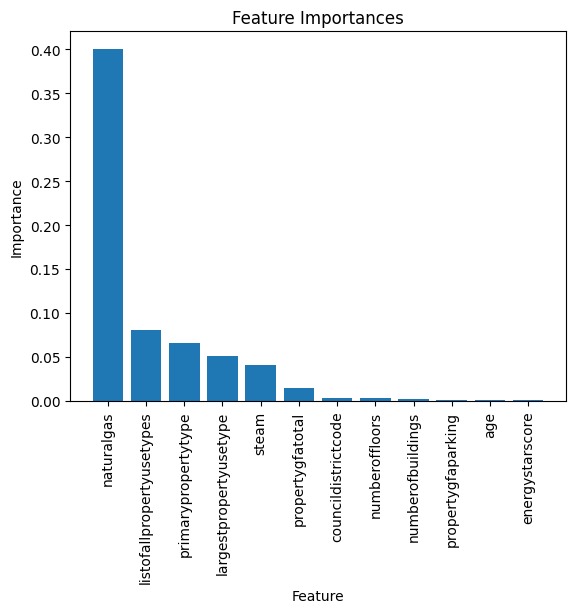

In [ ]:
# Extract the feature names and importances in separate lists
features = [x[0] for x in sorted_importances]
importances = [x[1] for x in sorted_importances]

# Create a bar plot of the feature importances
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
score = 0.8726
# TODO score in function of file name
score_curve = [score]
selection_score = {}
stop_count = 0
for f, feature in enumerate(reversed(features)):
    features.remove(feature)
    print('Removed Feature: {}\n'.format(feature))
    X_sel = X[features]
    # opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='gradient_based', tree_method='gpu_hist', missing=-999, device='cuda'), xg, X_sel, save=True)
    opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_sel, save=True)
    score_curve.append(score)
    selection_score[score] = features.copy()
    f += 1
    print('\nFEATURE SELECTION\n{}: {}\n\n\n\n'.format(f, features))
    # Check the score curve for early stopping
    # If the new score decreases substantially from the previous one
    if score_curve[-1] < score_curve[-2] - 0.02:
        stop_count += 1
    # If the score has decreased for more than 0.04, stop the loop
    if stop_count == 2:
        print("Early stopping due to substantial score decrease")
        break

Removed Feature: energystarscore

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ....... (step 1 of 2) Processing preparation, total=   0.1s
[Chain] ................... (1 of 8) Processing order 0, total=   1.4s
[Chain] ................... (2 of 8) Processing order 1, total=   2.2s
[Chain] ................... (3 of 8) Processing order 2, total=   2.5s
[Chain] ................... (4 of 8) Processing order 3, total=   5.5s
[Chain] ................... (5 of 8) Processing order 4, total=   3.5s
[Chain] ................... (6 of 8) Processing order 5, total=   4.2s
[Chain] ................... (7 of 8) Processing order 6, total=  10.0s
[Chain] ................... (8 of 8) Processing order 7, total=   4.3s
[Pipeline] ............. (step 2 of 2) Processing chain, total=  33.5s

CV parameters:
chain__base_estimator__colsample_bylevel: 0.46909356296798244
chain__base_estimator__colsample_bynode: 0.7549531688595925
chain__base_estimator__colsample_bytree: 0.93958119896305

Dès la première feature retirée, nous perdons plus de trois dixièmes en R2 score, donc autant toutes les garder.

In [ ]:
# Extract the CV score for 'totalghgemissions' target
totalghgemissions_cv_score = opt.cv_results_['mean_test_score'][targets.index('totalghgemissions')]
totalghgemissions_cv_score

#10.GLMM encoding

Ici, nous choisirons les six premières en nous inspirant du graphe, mais il serait également possible de créer un algorithme pour comparer les scores en fonction du nombre de features traitées.

In [ ]:
glmm = ['primarypropertytype', 'largestpropertyusetype']

In [ ]:
X_train_glmm = X_train[glmm]
X_test_glmm = X_test[glmm]
X_train_other = X_train.drop(glmm, axis=1)
X_test_other = X_test.drop(glmm, axis=1)

# totalghg = pd.DataFrame(y_train[:, -1], columns=['totalghgemissions'])
totalghg = y_train[:, -1]

encoder = GLMMEncoder(verbose=2, drop_invariant=True, return_df=True, handle_unknown='return_nan', handle_missing='return_nan', randomized=True, binomial_target=False)
X_train_glmm_encoded = encoder.fit_transform(X_train_glmm, totalghg)

In [ ]:
# Preprocess all categorical features except 'listofallpropertyusetypes' with a GLMM encoder based on 'totalghgemissions'
def glmm_encoder(X_train, y_train, X_test, glmm):
    X_train_glmm = X_train[glmm]
    X_test_glmm = X_test[glmm]
    X_train_other = X_train.drop(glmm, axis=1)
    X_test_other = X_test.drop(glmm, axis=1)

    # totalghg = pd.DataFrame(y_train[:, -1], columns=['totalghgemissions'])
    totalghg = y_train[:, -1]

    encoder = GLMMEncoder(verbose=2, drop_invariant=True, return_df=True, handle_unknown='return_nan', handle_missing='return_nan', randomized=True, binomial_target=False)
    X_train_glmm_encoded = encoder.fit_transform(X_train_glmm, totalghg)

    # Handle missing categories in the test set
    X_test_glmm_encoded = encoder.transform(X_test_glmm)
    # X_test_glmm_encoded = encoder.transform(X_test_glmm).fillna(-999)

    X_train_encoded = pd.concat([X_train_glmm_encoded, X_train_other], axis=1)
    X_test_encoded = pd.concat([X_test_glmm_encoded, X_test_other], axis=1)

    return X_train_encoded, X_test_encoded

In [ ]:
def find_hyperparameters(model, search_space, X=None, y=y, test_size=0.2, scoring=scoring, targets=targets, transfo_num=transfo_num, transfo_vec=transfo_vec, transfo_ord=transfo_ord, transfo_one=transfo_one, transfo_glmm=transfo_glmm, glmm=glmm, *, plot=False, save=False):
  '''print scores and return the feature importances if needed'''
  # split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  # Get the columns corresponding to the current selection of features
  num, vec, ord, one = get_columns(X)
  # Apply GLMM encoding to X_train only and apply the encoded values to X_test
  X_train_encoded, X_test_encoded = glmm_encoder(X_train, y_train, X_test, glmm)
  # Assign the encoded values back to X_train and X_test
  X_train = X_train_encoded
  X_test = X_test_encoded
  # create the pipeline
  pipe = chain_pipe(model, num, transfo_num, vec, transfo_vec, ord, transfo_ord, one, transfo_one, glmm, transfo_glmm)
  # use BayesSearchCV to find optimal hyperparameters
  opt = BayesSearchCV(
    pipe,
    search_space,
    n_iter=10,
    scoring=scoring,
    cv=5,
    n_jobs=-1,
    n_points=10,
    verbose=3,
    error_score='raise',
    random_state=42
    )
  opt.fit(X_train, y_train)
  # get CV scores
  evaluate_model(opt, X)
  # get predictions
  score = get_predictions(opt, X_test, y_test, targets)
  # plot learning curve
  if plot is True:
    plot_curve(opt, X)
  # Save the best model to a file
  elif save is True:
    file_name = str(model).split('(')[0] + '_' + str(len(X_train.columns)) + 'features_' + str(round(score,4)) + '.joblib'
    dump(opt.best_estimator_, file_name)
  return opt, score

In [ ]:
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
glmm = ['naturalgas', 'primarypropertytype', 'largestpropertyusetype']

In [ ]:
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ....... (step 1 of 2) Processing preparation, total=   0.1s
[Chain] ................... (1 of 8) Processing order 0, total=   1.8s
[Chain] ................... (2 of 8) Processing order 1, total=   2.4s
[Chain] ................... (3 of 8) Processing order 2, total=   6.1s
[Chain] ................... (4 of 8) Processing order 3, total=   3.3s
[Chain] ................... (5 of 8) Processing order 4, total=   3.7s
[Chain] ................... (6 of 8) Processing order 5, total=   8.0s
[Chain] ................... (7 of 8) Processing order 6, total=   5.0s
[Chain] ................... (8 of 8) Processing order 7, total=   8.5s
[Pipeline] ............. (step 2 of 2) Processing chain, total=  38.7s

CV parameters:
chain__base_estimator__colsample_bylevel: 0.46909356296798244
chain__base_estimator__colsample_bynode: 0.7549531688595925
chain__base_estimator__colsample_bytree: 0.9395811989630505
chain__base_estimator__grow_pol

#10.Comparaison des modèles

Laintenant que le nombre de feaytures

#10.1MLPRegressor

In [ ]:
mlp = {
    'preparation__vec__vectorizer__min_df': Real(1e-5, 0.5, prior='log-uniform'),
    'preparation__one__onehot__min_frequency': Real(1e-5, 1, prior='log-uniform'),
    'chain__base_estimator__hidden_layer_sizes': Categorical([(10,), (50,), (100,), (200,), (500,)]),
    'chain__base_estimator__activation': Categorical(['relu', 'logistic', 'tanh']),
    'chain__base_estimator__solver': Categorical(['adam', 'lbfgs']),
    'chain__base_estimator__alpha': Real(1e-5, 1.0, prior='log-uniform'),
    'chain__base_estimator__learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
    'chain__base_estimator__learning_rate_init': Real(1e-5, 1.0, prior='log-uniform'),
    'chain__base_estimator__max_iter': Integer(200, 1000)
}

In [ ]:
# Preprocess with OrdinalEncoder
transfo_ord = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputation', SimpleImputer(strategy='most_frequent')),
    ('scaling', PowerTransformer()),
])

In [ ]:
opt, score = find_hyperparameters(MLPRegressor(early_stopping=True), mlp, X, save=True)

#10.2Hubert

In [ ]:
def robust_pipe(model=None, X=X, transfo_num=transfo_num, transfo_cat1=transfo_cat1, transfo_cat2=transfo_cat2):
  '''Define the chain and preparation step, then concatenate'''
  chain = RegressorChain(model)

  preparation = ColumnTransformer(
    transformers=[
        ('num', transfo_num, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat1', transfo_cat1, [feature for feature in ['primarypropertytype', 'largestpropertyusetype'] if feature in X.columns]),
        ('cat2', transfo_cat2, ['listofallpropertyusetypes'] if 'listofallpropertyusetypes' in X.columns else [])
        ])

  pipe = Pipeline(steps=[
    ('preparation', preparation),
    ('chain', chain)
    ])
  return pipe

In [ ]:
# define the search space for HuberRegressor hyperparameters
huber = {
    'preparation__num__imputation__n_neighbors': Integer(2, 20),
    'chain__base_estimator__epsilon': Real(1.0, 3.0, prior='uniform'),
    'chain__base_estimator__alpha': Real(0.0001, 0.1, prior='log-uniform')
}

In [ ]:
# Use HuberRegressor to fit a robust non-linear model to the data
huber = HuberRegressor()
huber.fit(opt.predict(X_train), y_train)

# Evaluate the performance of the model on the test set
y_pred = huber.predict(xgb.predict(X_test))
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

#10.2HistGradientBoostingRegressor

In [ ]:
hgb = {
    'preparation__num__imputation__n_neighbors': Integer(2, 20),
    'chain__base_estimator__loss': Categorical(['squared_error', 'absolute_error', 'poisson', 'quantile']),
    'chain__base_estimator__learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'chain__base_estimator__max_iter': Categorical([i for i in range(100, 1001, 50)]),
    'chain__base_estimator__max_leaf_nodes': Integer(2, 500),
    'chain__base_estimator__min_samples_leaf': Integer(1, 50),
    'chain__base_estimator__l2_regularization': Real(1e-10, 1e-1, prior='log-uniform')
}

In [ ]:
opt, score = find_hyperparameters(HistGradientBoostingRegressor(), hgb)

In [ ]:
# define the search space for hyperparameters
n_features = X.shape[1]
rf = {
    'preparation__num__imputation__n_neighbors': Integer(2, 20),
    'chain__base_estimator__n_estimators': Categorical([i for i in range(100, 1001, 50)]),
    'chain__base_estimator__max_depth': Integer(2, 20),
    'chain__base_estimator__min_samples_split': Integer(2, 10),
    'chain__base_estimator__min_samples_leaf': Integer(1, 10),
    'chain__base_estimator__max_features': Integer(int(np.log2(n_features)), n_features),
    'chain__base_estimator__max_samples': Real(0.1, 1.0, prior='log-uniform')
}

#10.1 RandomForestRegressor

> Indented block



In [ ]:
opt, X_test, y_test = find_hyperparameters(RandomForestRegressor(), rf)

#11.Export du modèle choisi

In [ ]:
# Select the best hyperparameters
best_pipe = opt.best_estimator_
# Fit the pipeline on the original dataset
X = df.drop(targets, axis=1)
X = glmm_encoder(X)
best_pipe.fit(X, y)
# Save the resulting model to a file
dump(best_pipe, 'xgboost_model.joblib')
files.download('xgboost_model.joblib')